In [138]:
import matplotlib.pyplot as plt
import pandas as pd
import gpxpy
from datetime import datetime
import numpy as np
import scipy.fftpack

In [16]:
gpx = gpxpy.parse(open('20191209BUS23EW.gpx'))

print("{} track(s)".format(len(gpx.tracks)))
track = gpx.tracks[0]

print("{} segment(s)".format(len(track.segments)))
segment = track.segments[0]

print("{} point(s)".format(len(segment.points)))

1 track(s)
1 segment(s)
963 point(s)


In [70]:
data = []
segment_length = segment.length_3d()
for point_idx, point in enumerate(segment.points):
    data.append([point.longitude, point.latitude,
                 point.elevation, point.time, segment.get_speed(point_idx)])
    
from pandas import DataFrame

columns = ['Longitude', 'Latitude', 'Altitude', 'Time', 'Speed']
df = DataFrame(data, columns=columns)
df.head()

Longitude   Latitude  Altitude                             Time      Speed
0 -83.720873  42.298079   237.637 2019-12-09 20:36:41.958000+00:00   7.167167
1 -83.720952  42.298101   235.948 2019-12-09 20:36:42.986000+00:00   7.167165
2 -83.721089  42.298110   228.952 2019-12-09 20:36:43.971000+00:00  14.406155
3 -83.721258  42.298088   226.095 2019-12-09 20:36:44.971000+00:00  12.982798
4 -83.721390  42.298124   226.019 2019-12-09 20:36:45.971000+00:00  12.417379

In [71]:
#from 2019-12-09 20:40:53
#to 2019-12-09 20:51:47
df_GPS = df[211:211+653]
df_GPS = df_GPS.reset_index()
df_GPS = df_GPS.drop(columns='index')

In [72]:
for i,j in enumerate(df_GPS['Time']):
    df_GPS.loc[i,'s'] = datetime.timestamp(j)

In [73]:
import numpy as np
import seawater as sw
from oceans.filters import smoo1

_, angles = sw.dist(df_GPS['Latitude'], df_GPS['Longitude'])
angles = np.r_[0, np.deg2rad(angles)]

# Normalize the speed to use as the length of the arrows
r = df_GPS['Speed'] / df_GPS['Speed'].max()
kw = dict(window_len=20, window='hanning')
df_GPS['u'] = smoo1(r * np.cos(angles), **kw)
df_GPS['v'] = smoo1(r * np.sin(angles), **kw)

In [74]:
_, angles = sw.dist(df_GPS['Latitude'], df_GPS['Longitude'])
angles = np.r_[0, np.deg2rad(angles)]
smoo1(r * np.cos(angles), **kw).shape

(653,)

In [75]:
df_GPS.shape

(653, 8)

In [92]:
import mplleaflet
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
df_GPS = df_GPS.dropna()
ax.plot(df_GPS['Longitude'], df_GPS['Latitude'],
        color='darkorange', linewidth=5, alpha=0.6)
sub = 8
ax.quiver(df_GPS['Longitude'][::sub], df_GPS['Latitude'][::sub], df_GPS['u'][::sub], df_GPS['v'][::sub], color='r', alpha=0.8, scale=20)
mplleaflet.display(fig=fig, tiles='esri_aerial')

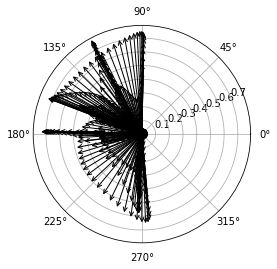

In [91]:
from oceans.ocfis import uv2spdir
u = df_GPS['u']
v = df_GPS['v']
wd, ws = uv2spdir(u,v)
fig, ax = plt.subplots(subplot_kw=dict(polar=True))
kw = dict(arrowstyle="->")
wd = np.deg2rad(wd)
lines = [ax.annotate("", xy=(d, s), xytext=(0, 0), arrowprops=kw) for d, s in zip(wd, ws)]
_ = ax.set_ylim(0, np.max(ws))

In [95]:
df = pd.read_csv('df.csv',header=None)
df = df.iloc[68:,:]
df = df.rename(columns={0:'time',1:'xyz'})

In [169]:
def t2s(t):
    hms = t.str.split(".")
    t2 = pd.DataFrame(hms.values.tolist(), index= hms.index).iloc[:,0]
    t2 = t2.str.split(":")
    h = pd.DataFrame(t2.values.tolist(), index= t2.index).iloc[:,0]
    m = pd.DataFrame(t2.values.tolist(), index= t2.index).iloc[:,1]
    s = pd.DataFrame(t2.values.tolist(), index= t2.index).iloc[:,2]
    return (h.astype(int) * 3600 + m.astype(int) * 60 + s.astype(int))

In [170]:
df['s'] = t2s(df['time'])

In [171]:
acc_index = [x*4 for x in range(int(len(df)/4))]
acceleration = df.iloc[acc_index,:]
gyro_index = [x*4+1 for x in range(int(len(df)/4))]
gyro = df.iloc[gyro_index,:]
mag_index = [x*4+2 for x in range(int(len(df)/4))]
mag = df.iloc[mag_index,:]
temp_index = [x*4+3 for x in range(int(len(df)/4))]
temp = df.iloc[temp_index,:]

In [172]:
acceleration.shape

(900, 3)

In [173]:
acc_df = pd.DataFrame(list(acceleration['xyz'].str.split()))
acc_df = acc_df.iloc[:,[1,4,7]]
acc_df = acc_df.rename(columns={1:'x',4:'y',7:'z'})
acc_df = acc_df.astype(float)
acc_df['s'] = (acceleration.reset_index())['s']
acc_df = acc_df.drop_duplicates('s')
acc_df = acc_df.reset_index()
acc_df = acc_df.drop(columns='index')

In [174]:
gyro_df = pd.DataFrame(list(gyro['xyz'].str.split()))
gyro_df = gyro_df.iloc[:,[2,6,10]]
gyro_df = gyro_df.rename(columns={2:'x',6:'y',10:'z'})
gyro_df = gyro_df.astype(float)
gyro_df['s'] = (gyro.reset_index())['s']
gyro_df = gyro_df.drop_duplicates('s')
gyro_df = gyro_df.reset_index()
gyro_df = gyro_df.drop(columns='index')

In [175]:
mag_df = pd.DataFrame(list(mag['xyz'].str.split()))
mag_df = mag_df.iloc[:,[2,6,10]]
mag_df = mag_df.rename(columns={2:'x',6:'y',10:'z'})
mag_df = mag_df.astype(float)
mag_df['s'] = (mag.reset_index())['s']
mag_df = mag_df.drop_duplicates('s')
mag_df = mag_df.reset_index()
mag_df = mag_df.drop(columns='index')

In [176]:
temp_df = pd.DataFrame(list(temp['xyz'].str.split()))
temp_df = temp_df.iloc[:,2]
temp_df = temp_df.rename(columns={2:'T'})
temp_df = temp_df.astype(float)
temp_df = pd.DataFrame(temp_df)
temp_df['s'] = (temp.reset_index())['s']
temp_df = temp_df.drop_duplicates('s')
temp_df = temp_df.reset_index()
temp_df = temp_df.drop(columns='index')

In [330]:
plt.rcParams['figure.figsize'] = (18.0, 1.0)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

Text(0, 0.5, 'acceleration (mg)')

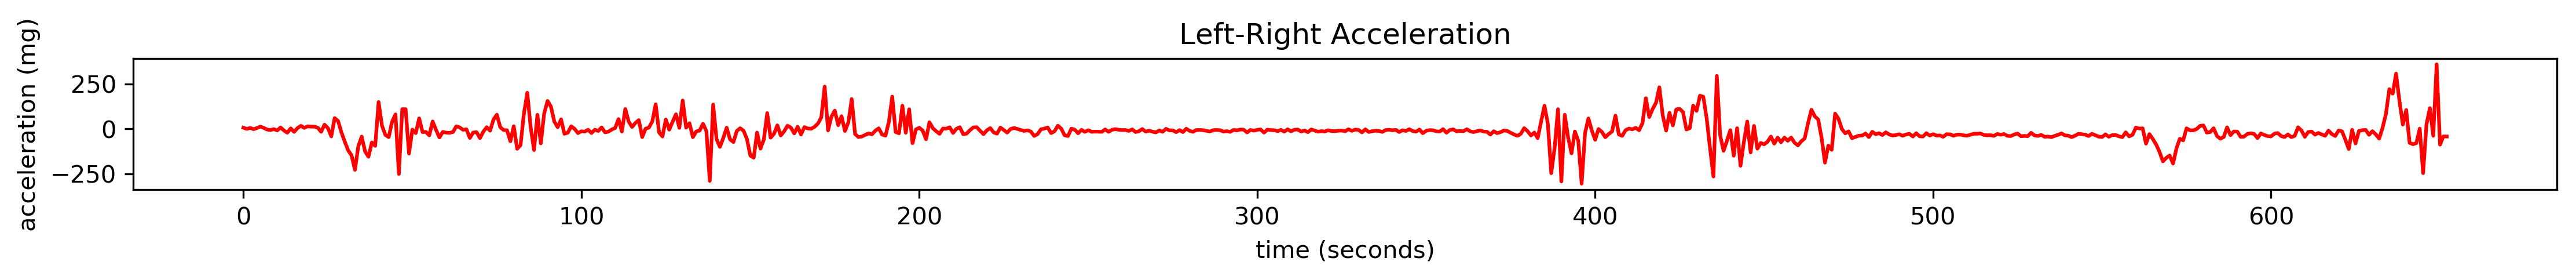

In [178]:
plt.plot(acc_df.loc[:,'x'].values,c='r')
plt.title('Left-Right Acceleration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

Text(0, 0.5, 'acceleration (mg)')

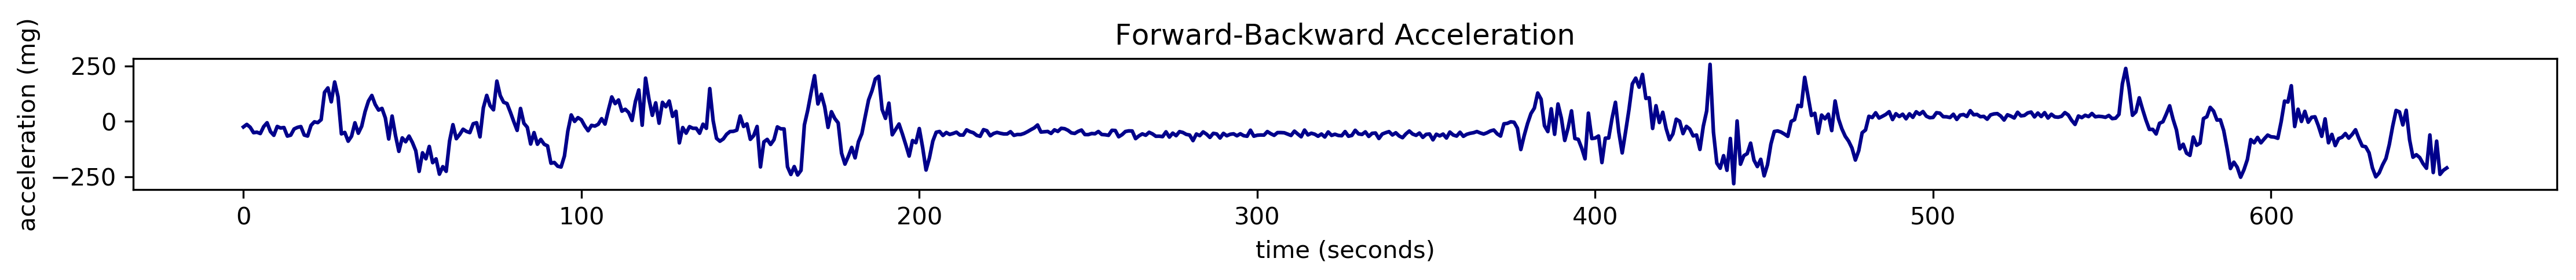

In [179]:
plt.plot(acc_df.loc[:,'y'].values,c='darkblue')
plt.title('Forward-Backward Acceleration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

Text(0, 0.5, 'acceleration (mg)')

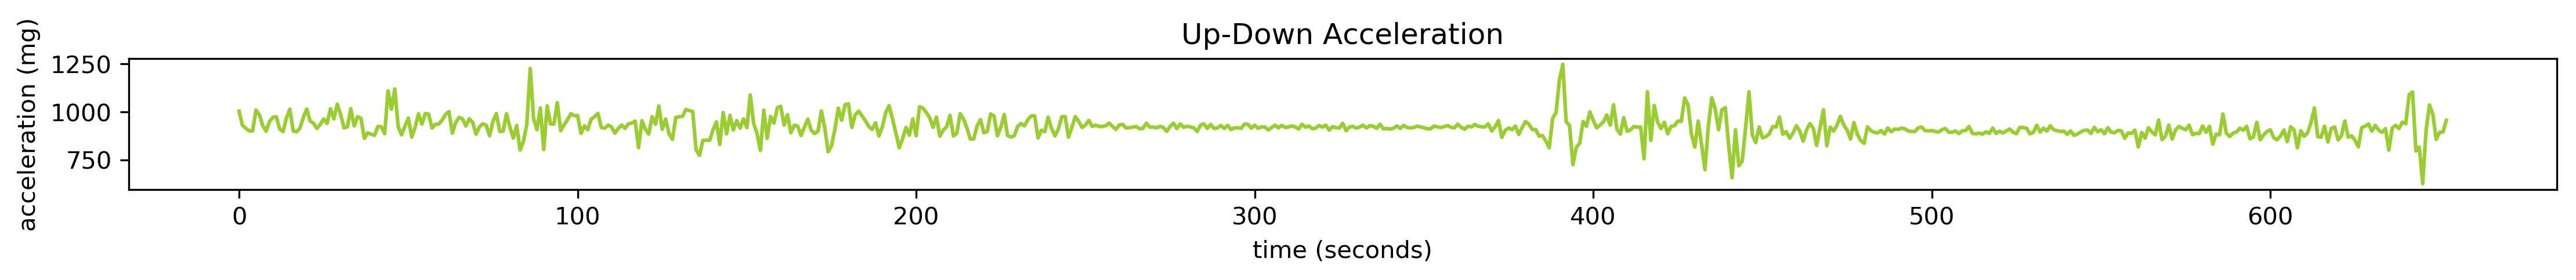

In [180]:
plt.plot(acc_df.loc[:,'z'].values,c='yellowgreen')
plt.title('Up-Down Acceleration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

Text(0, 0.5, 'x-axis ratation')

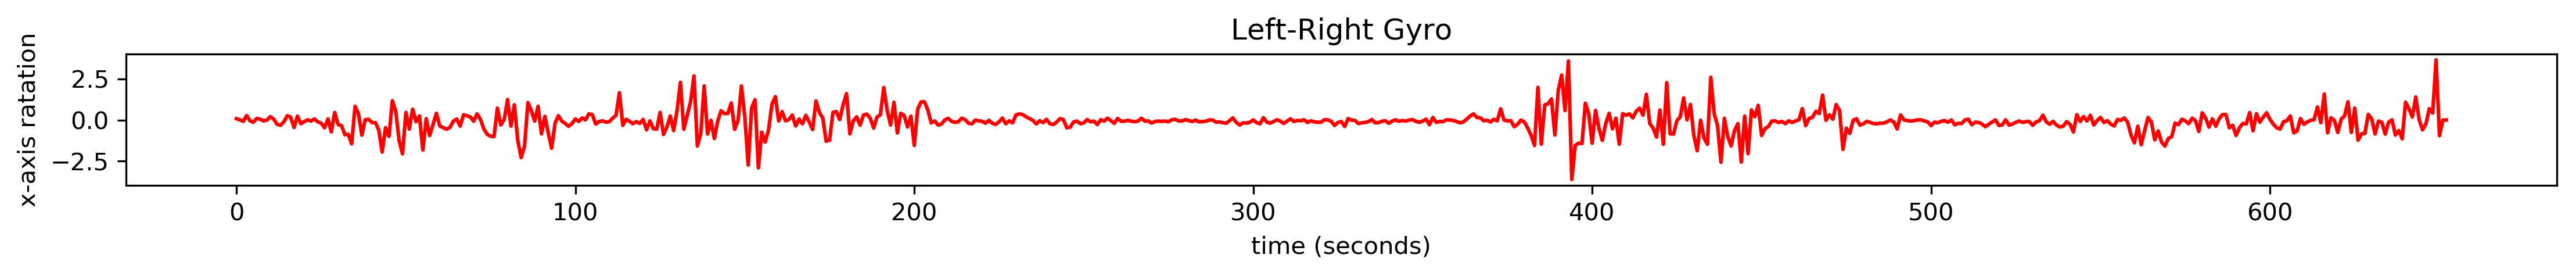

In [181]:
plt.plot(gyro_df.loc[:,'x'].values,c='r')
plt.title('Left-Right Gyro')
plt.xlabel('time (seconds)')
plt.ylabel('x-axis ratation')

Text(0, 0.5, 'y-axis ratation')

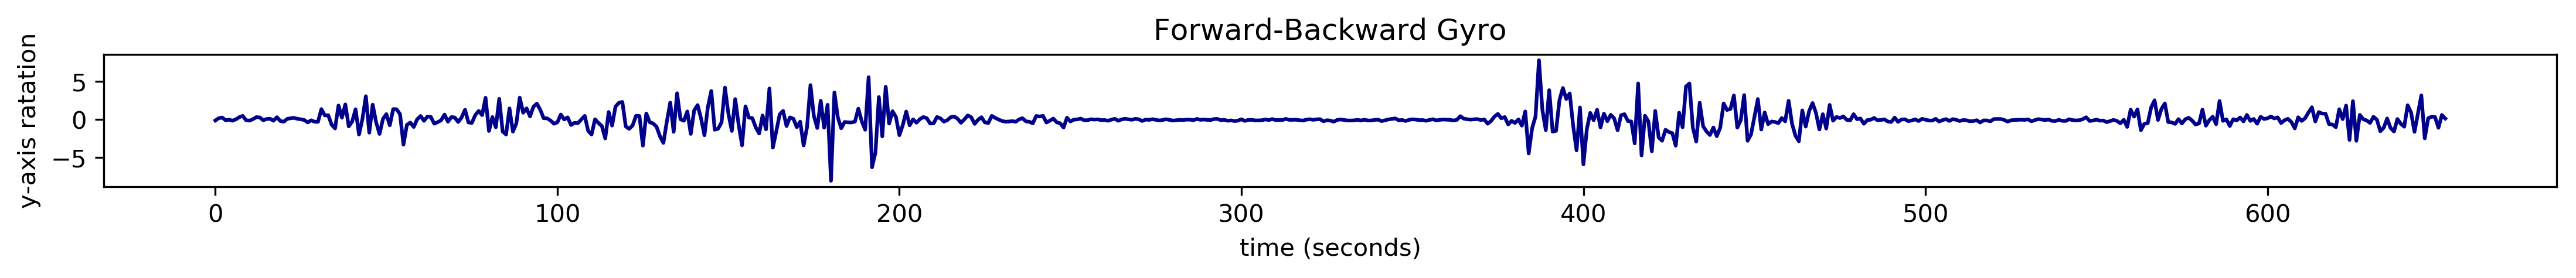

In [182]:
plt.plot(gyro_df.loc[:,'y'].values,c='darkblue')
plt.title('Forward-Backward Gyro')
plt.xlabel('time (seconds)')
plt.ylabel('y-axis ratation')

Text(0, 0.5, 'z-axis ratation')

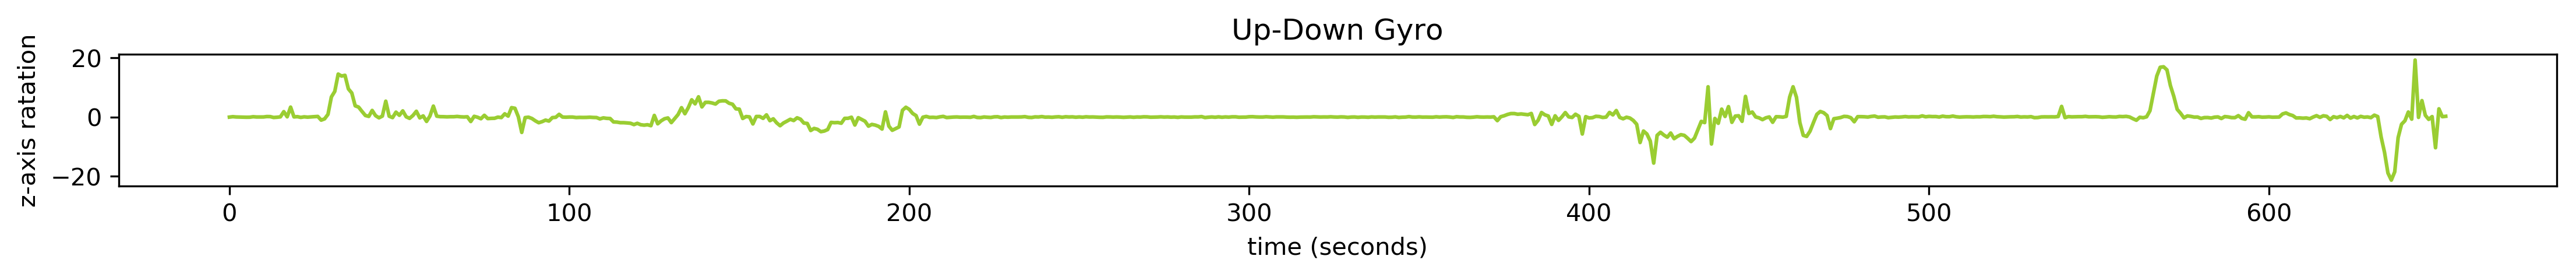

In [183]:
plt.plot(gyro_df.loc[:,'z'].values,c='yellowgreen')
plt.title('Up-Down Gyro')
plt.xlabel('time (seconds)')
plt.ylabel('z-axis ratation')

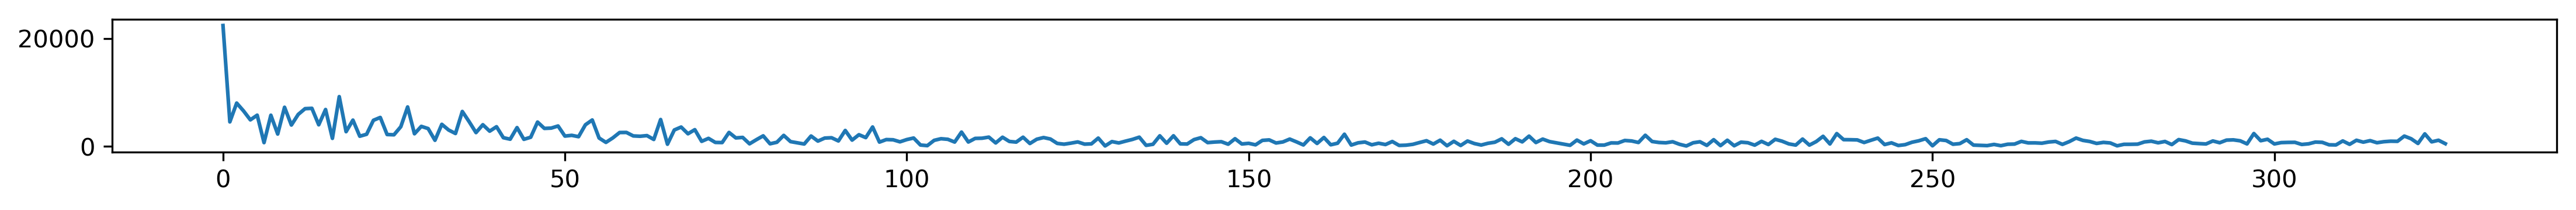

In [184]:
test = scipy.fftpack.fft(acc_df.loc[:,'y'].values)
plt.plot(np.abs(test)[:int(len(test)/2)])

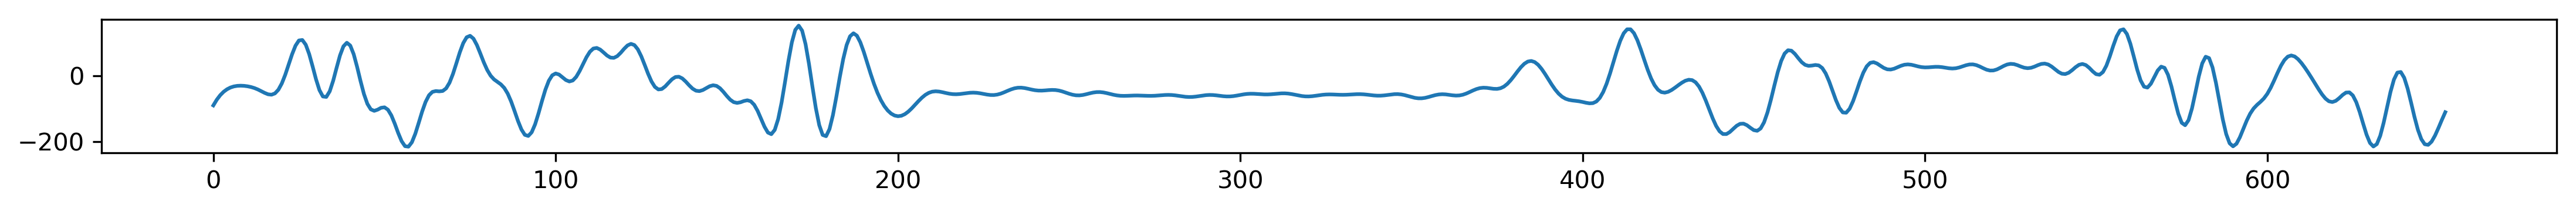

In [185]:
test = scipy.fftpack.fft(acc_df.loc[:,'y'].values)
b = test#[:int(len(test)/2)]
b[60:-60] = 0
#b[:100] = 0
#b[-100:] = 0
c = scipy.fftpack.ifft(b)
plt.plot(c)

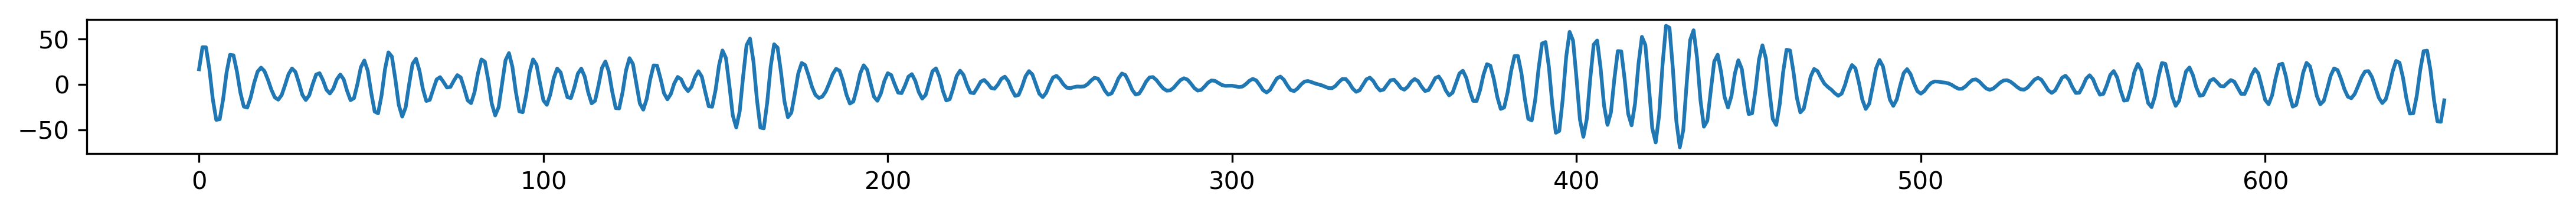

In [186]:
test = scipy.fftpack.fft(acc_df.loc[:,'y'].values)
b = test#[:int(len(test)/2)]
b[100:-100] = 0
b[:70] = 0
b[-70:] = 0
#b[:100] = 0
#b[-100:] = 0
c = scipy.fftpack.ifft(b)
plt.plot(c)

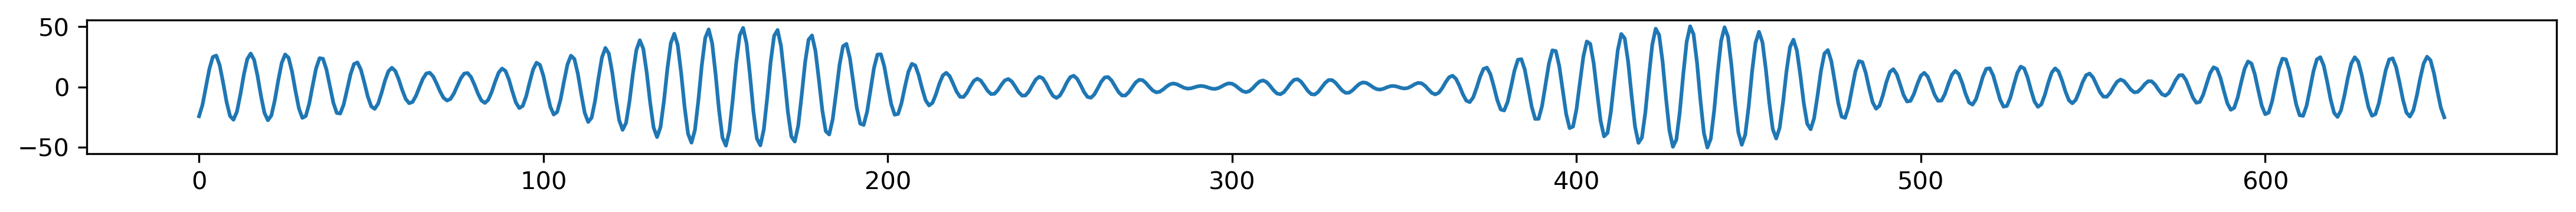

In [187]:
test = scipy.fftpack.fft(acc_df.loc[:,'y'].values)
b = test#[:int(len(test)/2)]
b[70:-70] = 0
b[:60] = 0
b[-60:] = 0
#b[:100] = 0
#b[-100:] = 0
c = scipy.fftpack.ifft(b)
plt.plot(c)

In [188]:
acc_df.head()

x      y        z      s
0  6.96 -25.33  1003.48  56453
1  0.00 -13.85   930.60  56454
2  5.55 -26.55   914.31  56455
3 -1.46 -51.15   901.49  56456
4  5.00 -49.07   900.88  56457

In [189]:
acc_df = acc_df.rename(columns={'x':'acc_x','y':'acc_y','z':'acc_z'}).iloc[:,:3]
gyro_df = gyro_df.rename(columns={'x':'gyro_x','y':'gyro_y','z':'gyro_z'}).iloc[:,:3]
mag_df = mag_df.rename(columns={'x':'mag_x','y':'mag_y','z':'mag_z'}).iloc[:,:3]
temp_df = temp_df.rename(columns={0:'temp'}).iloc[:,:1]

In [193]:
data = pd.concat([df_GPS,acc_df,gyro_df,mag_df,temp_df], axis=1, join_axes=[df_GPS.index])

In [194]:
data.to_csv('20191209BUS23EW.csv')

In [200]:
import geopandas as gpd
from shapely.geometry import LineString,Point

In [197]:
xyList = [xy for xy in zip(data.Longitude, data.Latitude)]

In [221]:
data.head()

Longitude   Latitude  Altitude                             Time     Speed  \
0 -83.738361  42.290189   203.071 2019-12-09 20:40:53.970000+00:00  0.871020   
1 -83.738348  42.290183   202.920        2019-12-09 20:40:55+00:00  0.963638   
2 -83.738345  42.290178   203.092        2019-12-09 20:40:56+00:00  1.323603   
3 -83.738325  42.290180   204.311        2019-12-09 20:40:57+00:00  1.540756   
4 -83.738314  42.290180   204.803        2019-12-09 20:40:58+00:00  1.034718   

              s         u         v  acc_x  acc_y    acc_z  gyro_x  gyro_y  \
0  1.575924e+09  0.052498 -0.005774   6.96 -25.33  1003.48   0.084  -0.114   
1  1.575924e+09  0.054331 -0.003356   0.00 -13.85   930.60   0.015   0.183   
2  1.575924e+09  0.056184 -0.000757   5.55 -26.55   914.31  -0.076   0.267   
3  1.575924e+09  0.057736  0.002071  -1.46 -51.15   901.49   0.275  -0.092   
4  1.575924e+09  0.058629  0.005152   5.00 -49.07   900.88  -0.046  -0.008   

   gyro_z   mag_x   mag_y   mag_z  temp  
0  -0.008  421.23  297.77  324.64  25.5  
1   0.137  413.97  286.88  265.30  25.5  
2   0.038  423.05  288.69  284.50  25.5  
3   0.008  437.58  288.69  305.44  25.5  
4  -0.038  412.16  292.32  267.04  25.5

In [230]:
print(LineString([xyList[i],xyList[i+1]]))

LINESTRING (-83.73836111999999 42.29018889, -83.7383476 42.29018263)


In [235]:
Data = gpd.GeoDataFrame(data)
Data['geometry'] = None
for i in range(len(xyList)-1):
    Data.loc[i,'geometry'] = LineString([xyList[i],xyList[i+1]])

Text(0, 0.5, 'acceleration (mg)')

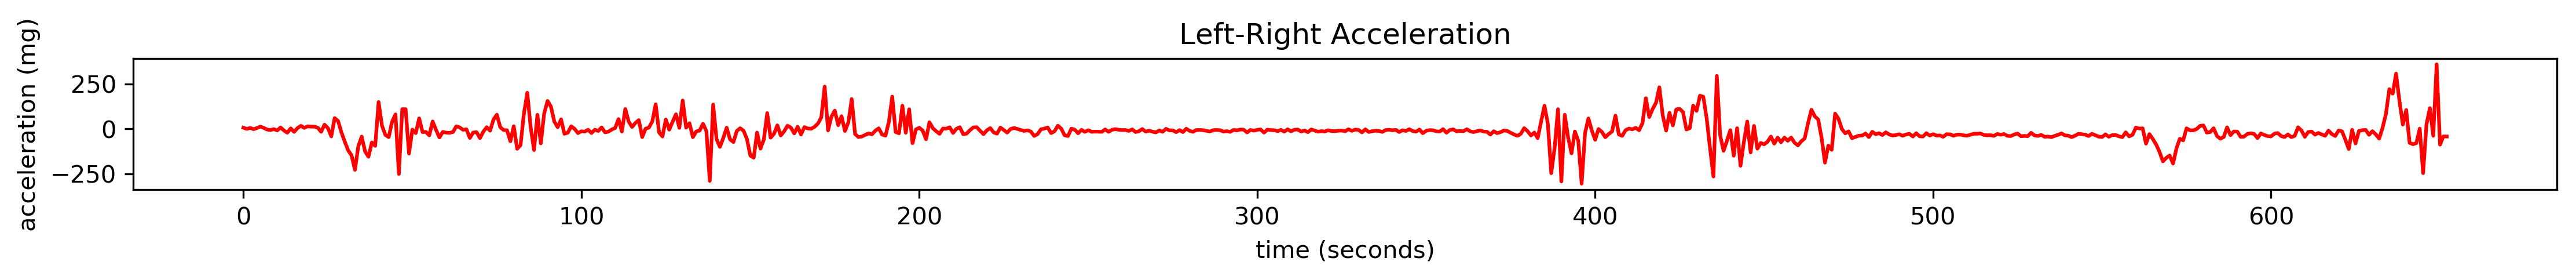

In [254]:
plt.plot(Data.loc[:,'acc_x'].values,c='r')
plt.title('Left-Right Acceleration')
plt.xlabel('time (seconds)')
plt.ylabel('acceleration (mg)')

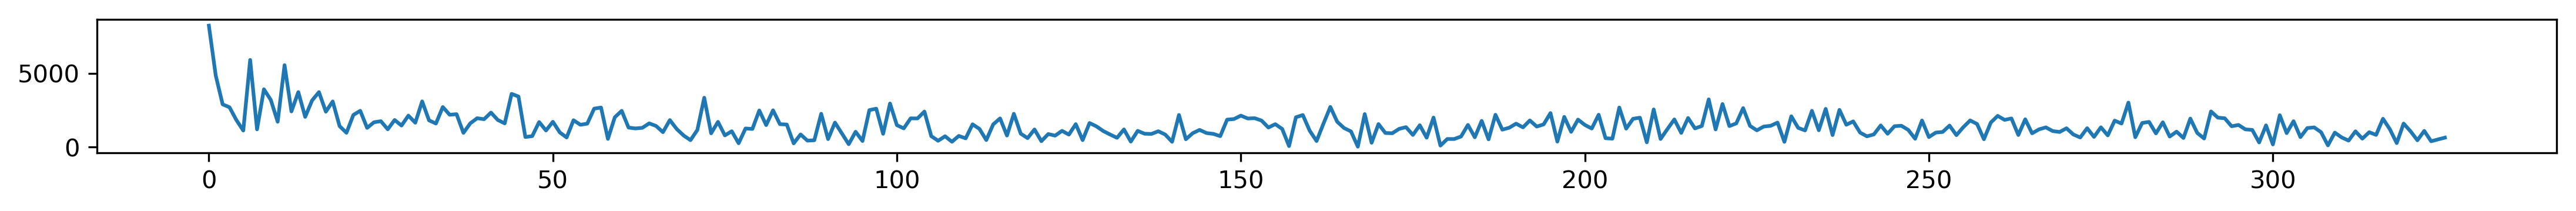

In [343]:
acc_x_fft = scipy.fftpack.fft(Data.loc[:,'acc_x'].values)
plt.plot(np.abs(acc_x_fft)[:int(len(acc_x_fft)/2)])

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


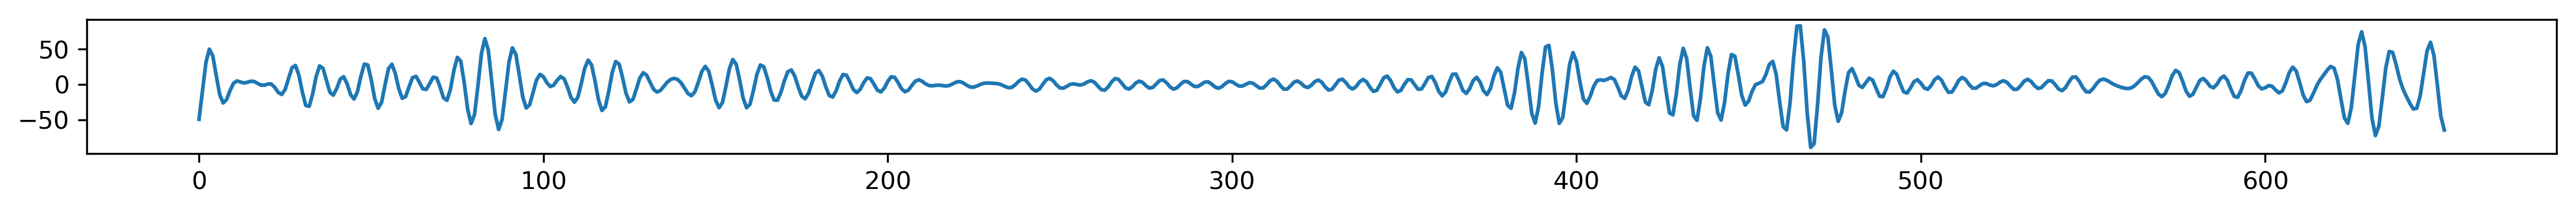

In [344]:
acc_x_fft = scipy.fftpack.fft(Data.loc[:,'acc_x'].values)
b = acc_x_fft
b[100:-100] = 0
b[:60] = 0
b[-60:] = 0
c = scipy.fftpack.ifft(b)
Data['acc_x_oscillation'] = c.astype(float)
plt.plot(c)

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


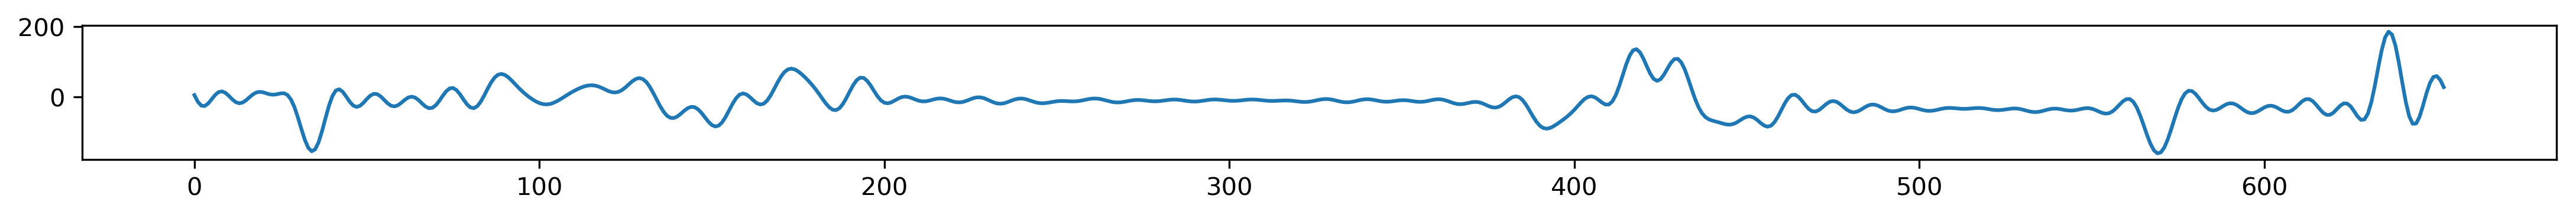

In [345]:
acc_x_fft = scipy.fftpack.fft(Data.loc[:,'acc_x'].values)
b = acc_x_fft
b[60:-60] = 0
c = scipy.fftpack.ifft(b)
Data['acc_x_direction'] = c.astype(float)
plt.plot(c)

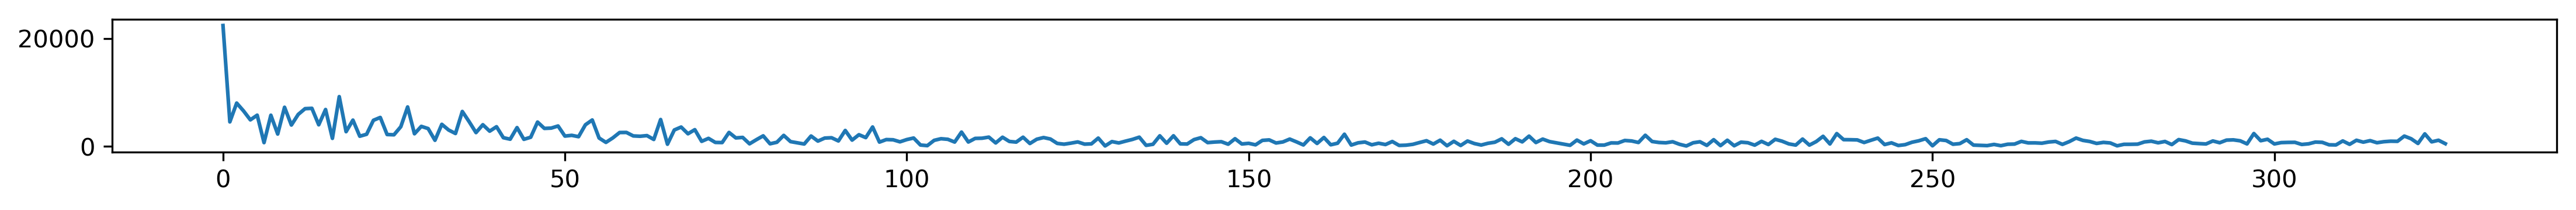

In [348]:
acc_y_fft = scipy.fftpack.fft(Data.loc[:,'acc_y'].values)
plt.plot(np.abs(acc_y_fft)[:int(len(acc_y_fft)/2)])

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


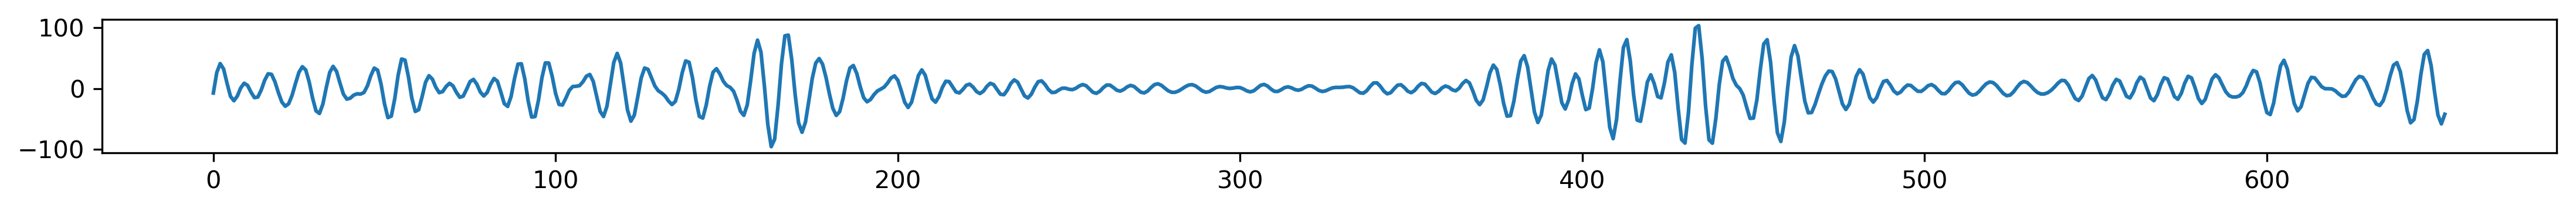

In [349]:
acc_y_fft = scipy.fftpack.fft(Data.loc[:,'acc_y'].values)
b = acc_y_fft
b[100:-100] = 0
b[:60] = 0
b[-60:] = 0
c = scipy.fftpack.ifft(b)
Data['acc_y_oscillation'] = c.astype(float)
plt.plot(c)

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


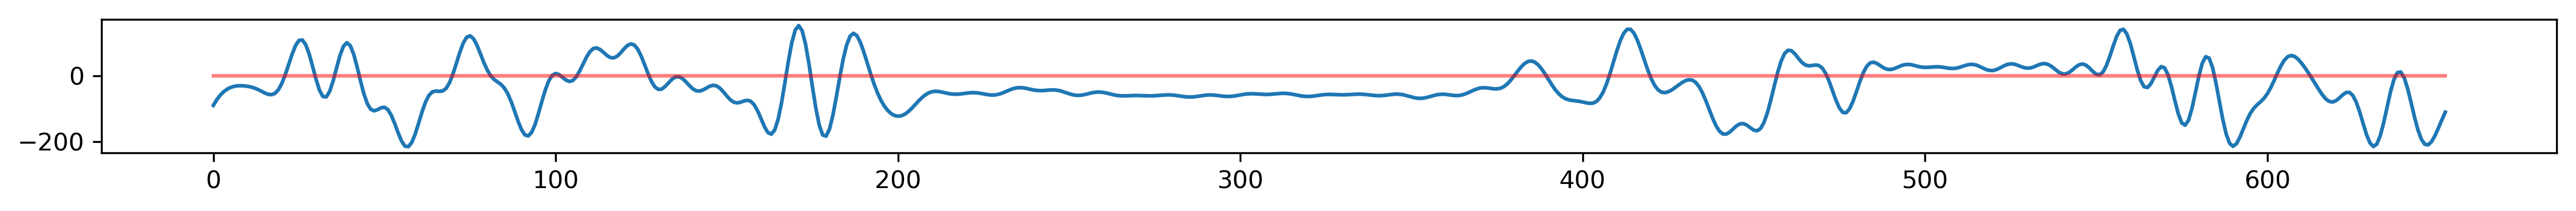

In [371]:
acc_y_fft = scipy.fftpack.fft(Data.loc[:,'acc_y'].values)
b = acc_y_fft
b[60:-60] = 0
c = scipy.fftpack.ifft(b)
Data['acc_y_fb'] = c.astype(float)
plt.plot(c)
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')

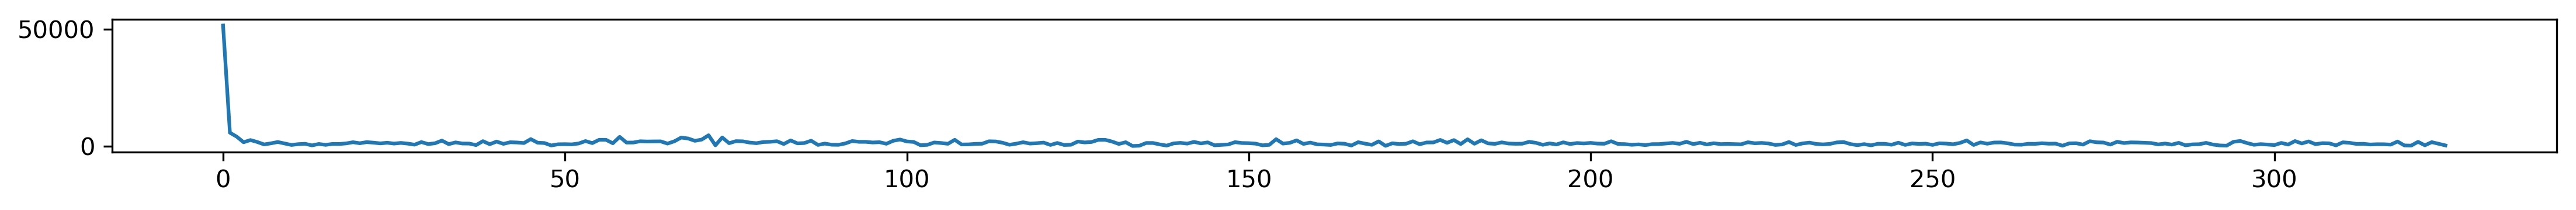

In [401]:
acc_z_fft = scipy.fftpack.fft(Data.loc[:,'acc_z'].values-1000)
plt.plot(np.abs(acc_z_fft)[:int(len(acc_z_fft)/2)])

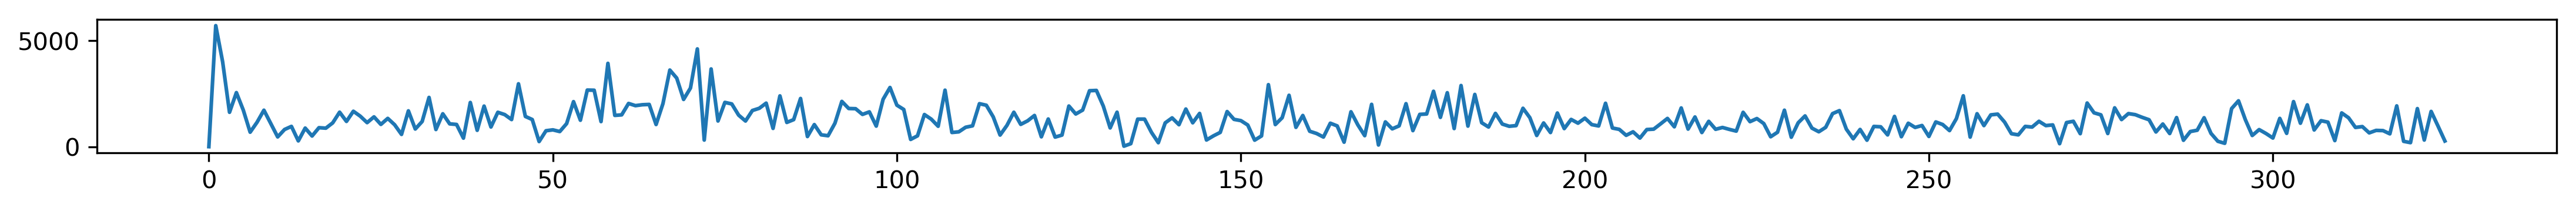

In [402]:
acc_z_fft = scipy.fftpack.fft(Data.loc[:,'acc_z'].values-1000)
b = acc_z_fft
b[:1] = 0
b[-1:] = 0
plt.plot(np.abs(acc_z_fft)[:int(len(b)/2)])

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


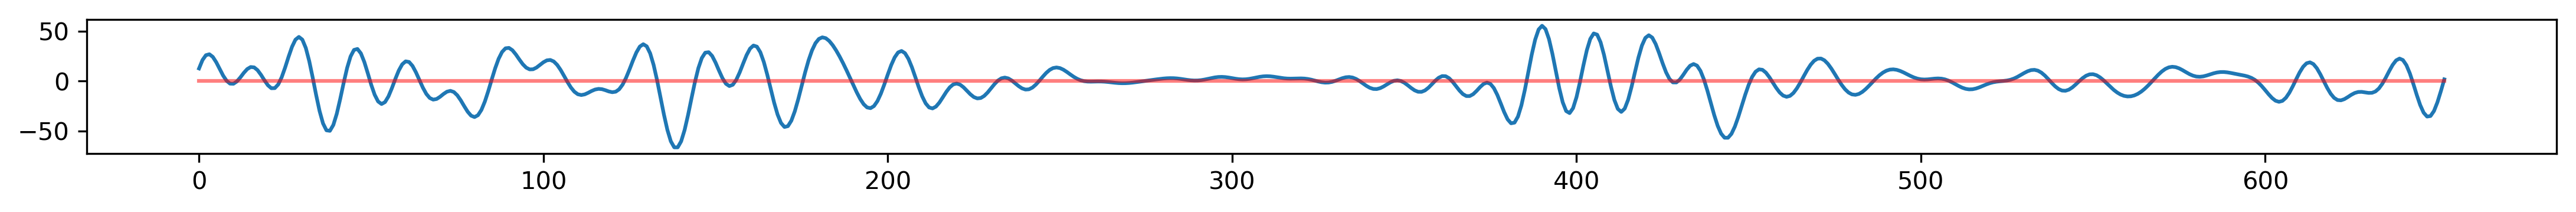

In [448]:
acc_z_fft = scipy.fftpack.fft(Data.loc[:,'acc_z'].values-1000)
b = acc_z_fft
b[50:-50] = 0
b[:5] = 0
b[-5:] = 0
c = scipy.fftpack.ifft(b)
Data['acc_z_pavement'] = c.astype(float)
plt.plot(c)
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')

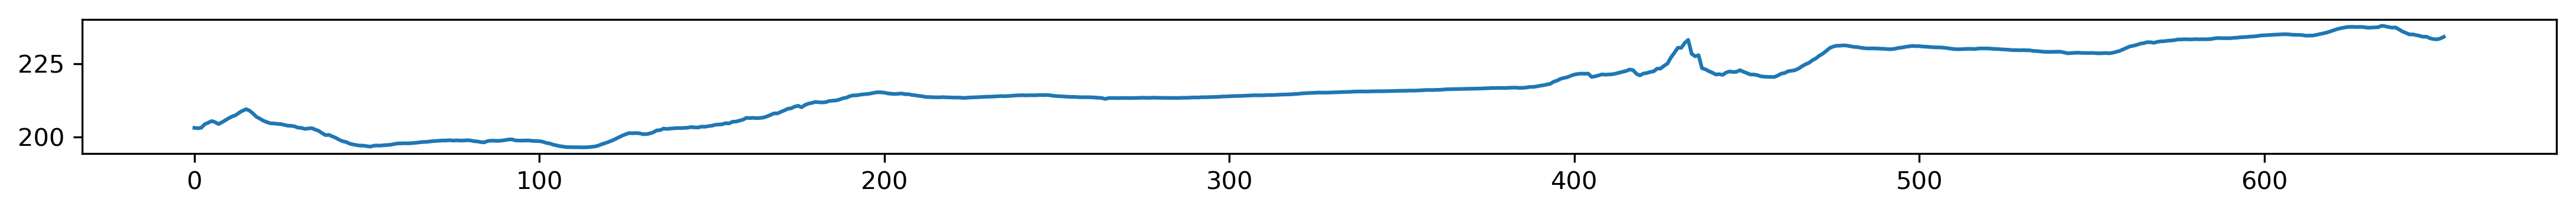

In [449]:
plt.plot(Data.loc[:,'Altitude'].values)

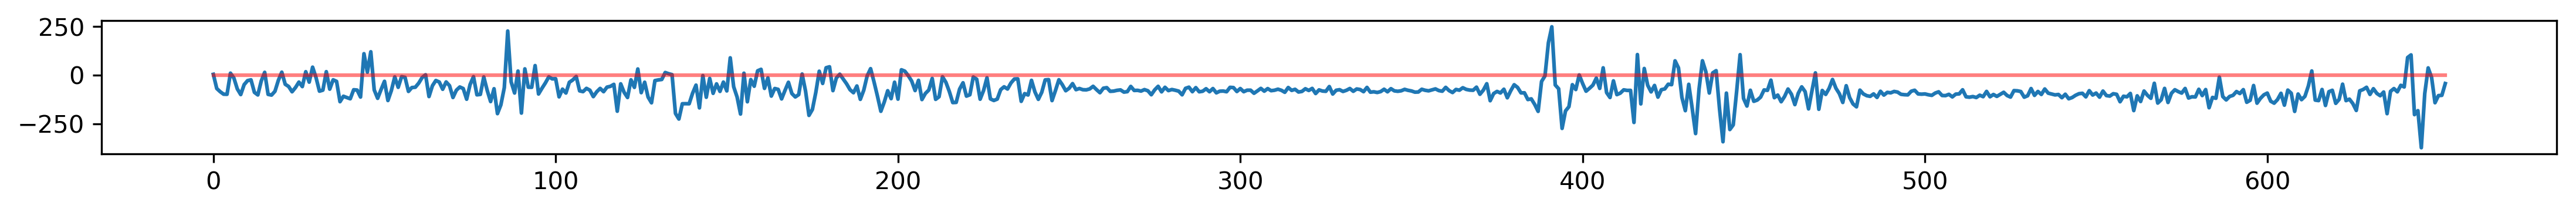

In [442]:
plt.plot(Data.loc[:,'acc_z'].values-1000)
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')

/Users/apple/anaconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


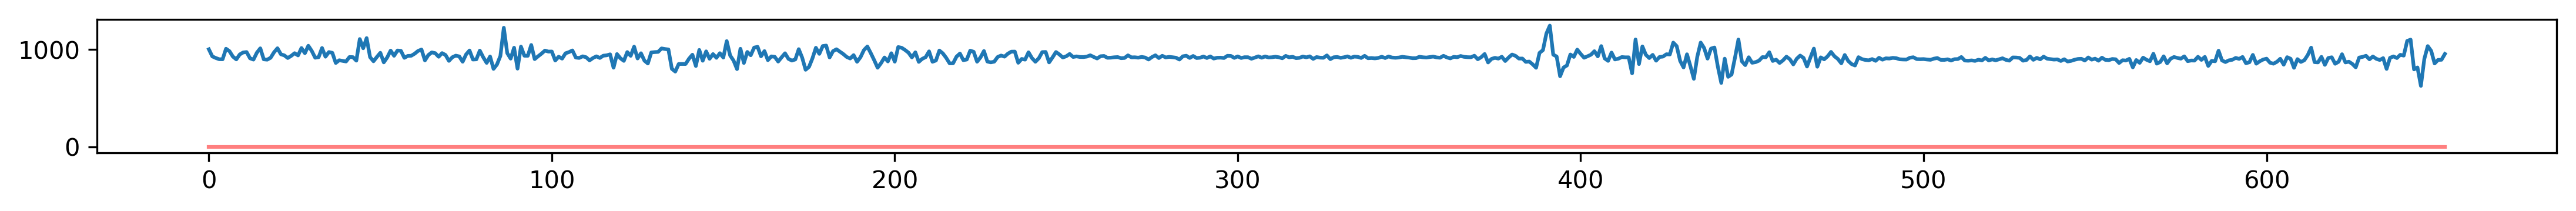

In [392]:
acc_z_fft = scipy.fftpack.fft(Data.loc[:,'acc_z'].values)
b = acc_z_fft
# b[80:-80] = 0
# b[:60] = 0
# b[-60:] = 0
c = scipy.fftpack.ifft(b)
Data['acc_z_pavement'] = c.astype(float)
plt.plot(c)
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')

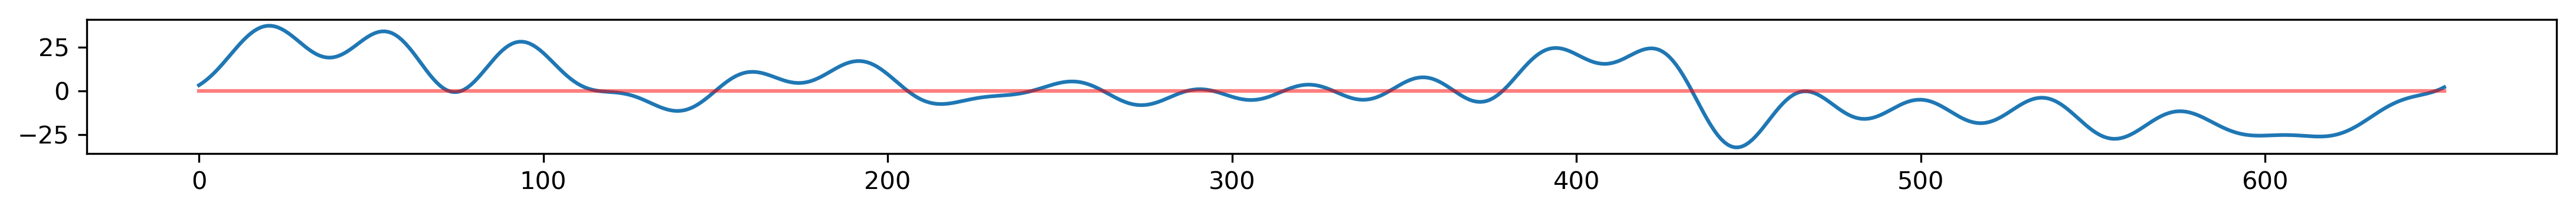

In [387]:
acc_z_fft = scipy.fftpack.fft(Data.loc[:,'acc_z'].values)
b = acc_z_fft
b[0:-20] = 0
b[:1] = 0
b[-1:] = 0
c = scipy.fftpack.ifft(b)
#Data['acc_z_pavement'] = c.astype(float)
plt.plot(c)
plt.plot(np.zeros(len(c)),alpha=0.5,c='r')

In [384]:
Data

Longitude   Latitude  Altitude                             Time  \
0   -83.738361  42.290189   203.071 2019-12-09 20:40:53.970000+00:00   
1   -83.738348  42.290183   202.920        2019-12-09 20:40:55+00:00   
2   -83.738345  42.290178   203.092        2019-12-09 20:40:56+00:00   
3   -83.738325  42.290180   204.311        2019-12-09 20:40:57+00:00   
4   -83.738314  42.290180   204.803        2019-12-09 20:40:58+00:00   
5   -83.738304  42.290180   205.392        2019-12-09 20:40:59+00:00   
6   -83.738289  42.290185   205.017        2019-12-09 20:41:00+00:00   
7   -83.738280  42.290190   204.353        2019-12-09 20:41:01+00:00   
8   -83.738275  42.290196   204.983        2019-12-09 20:41:02+00:00   
9   -83.738267  42.290196   205.667        2019-12-09 20:41:03+00:00   
10  -83.738260  42.290200   206.390        2019-12-09 20:41:04+00:00   
11  -83.738256  42.290205   206.993        2019-12-09 20:41:05+00:00   
12  -83.738254  42.290206   207.413        2019-12-09 20:41:06+00:00   
13  -83.738252  42.290205   208.281        2019-12-09 20:41:07+00:00   
14  -83.738255  42.290209   208.941        2019-12-09 20:41:08+00:00   
15  -83.738258  42.290207   209.448        2019-12-09 20:41:09+00:00   
16  -83.738250  42.290210   208.952        2019-12-09 20:41:10+00:00   
17  -83.738243  42.290212   207.963        2019-12-09 20:41:11+00:00   
18  -83.738234  42.290216   206.811        2019-12-09 20:41:12+00:00   
19  -83.738231  42.290217   206.206        2019-12-09 20:41:13+00:00   
20  -83.738227  42.290219   205.503        2019-12-09 20:41:14+00:00   
21  -83.738224  42.290221   205.033        2019-12-09 20:41:15+00:00   
22  -83.738223  42.290223   204.632        2019-12-09 20:41:16+00:00   
23  -83.738224  42.290221   204.556        2019-12-09 20:41:17+00:00   
24  -83.738225  42.290207   204.455        2019-12-09 20:41:18+00:00   
25  -83.738234  42.290181   204.343        2019-12-09 20:41:19+00:00   
26  -83.738251  42.290143   204.094        2019-12-09 20:41:20+00:00   
27  -83.738272  42.290093   203.816        2019-12-09 20:41:21+00:00   
28  -83.738301  42.290034   203.761        2019-12-09 20:41:22+00:00   
29  -83.738330  42.289976   203.594        2019-12-09 20:41:23+00:00   
..         ...        ...       ...                              ...   
623 -83.731103  42.278360   237.382        2019-12-09 20:51:18+00:00   
624 -83.731100  42.278262   237.582        2019-12-09 20:51:19+00:00   
625 -83.731097  42.278161   237.658        2019-12-09 20:51:20+00:00   
626 -83.731095  42.278063   237.642        2019-12-09 20:51:21+00:00   
627 -83.731092  42.277969   237.594        2019-12-09 20:51:22+00:00   
628 -83.731090  42.277879   237.639        2019-12-09 20:51:23+00:00   
629 -83.731088  42.277797   237.526        2019-12-09 20:51:24+00:00   
630 -83.731087  42.277715   237.348        2019-12-09 20:51:25+00:00   
631 -83.731085  42.277659   237.400        2019-12-09 20:51:26+00:00   
632 -83.731086  42.277613   237.440        2019-12-09 20:51:27+00:00   
633 -83.731086  42.277570   237.525        2019-12-09 20:51:28+00:00   
634 -83.731107  42.277536   238.025        2019-12-09 20:51:29+00:00   
635 -83.731152  42.277503   237.855        2019-12-09 20:51:30+00:00   
636 -83.731220  42.277487   237.590        2019-12-09 20:51:31+00:00   
637 -83.731312  42.277480   237.379        2019-12-09 20:51:32+00:00   
638 -83.731404  42.277473   237.449        2019-12-09 20:51:33+00:00   
639 -83.731530  42.277473   236.797        2019-12-09 20:51:34+00:00   
640 -83.731663  42.277473   236.086        2019-12-09 20:51:35+00:00   
641 -83.731800  42.277472   235.590        2019-12-09 20:51:36+00:00   
642 -83.731937  42.277472   235.069        2019-12-09 20:51:37+00:00   
643 -83.732069  42.277473   235.062        2019-12-09 20:51:38+00:00   
644 -83.732196  42.277473   234.824        2019-12-09 20:51:39+00:00   
645 -83.732317  42.277472   234.581        2019-12-09 20:51:40+00:00   
646 -83.732425  42.277472   234.255        20

In [301]:
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['figure.dpi'] = 72

In [244]:
Data['acc_y'].max()

257.69

In [346]:
Data

Longitude   Latitude  Altitude                             Time  \
0   -83.738361  42.290189   203.071 2019-12-09 20:40:53.970000+00:00   
1   -83.738348  42.290183   202.920        2019-12-09 20:40:55+00:00   
2   -83.738345  42.290178   203.092        2019-12-09 20:40:56+00:00   
3   -83.738325  42.290180   204.311        2019-12-09 20:40:57+00:00   
4   -83.738314  42.290180   204.803        2019-12-09 20:40:58+00:00   
5   -83.738304  42.290180   205.392        2019-12-09 20:40:59+00:00   
6   -83.738289  42.290185   205.017        2019-12-09 20:41:00+00:00   
7   -83.738280  42.290190   204.353        2019-12-09 20:41:01+00:00   
8   -83.738275  42.290196   204.983        2019-12-09 20:41:02+00:00   
9   -83.738267  42.290196   205.667        2019-12-09 20:41:03+00:00   
10  -83.738260  42.290200   206.390        2019-12-09 20:41:04+00:00   
11  -83.738256  42.290205   206.993        2019-12-09 20:41:05+00:00   
12  -83.738254  42.290206   207.413        2019-12-09 20:41:06+00:00   
13  -83.738252  42.290205   208.281        2019-12-09 20:41:07+00:00   
14  -83.738255  42.290209   208.941        2019-12-09 20:41:08+00:00   
15  -83.738258  42.290207   209.448        2019-12-09 20:41:09+00:00   
16  -83.738250  42.290210   208.952        2019-12-09 20:41:10+00:00   
17  -83.738243  42.290212   207.963        2019-12-09 20:41:11+00:00   
18  -83.738234  42.290216   206.811        2019-12-09 20:41:12+00:00   
19  -83.738231  42.290217   206.206        2019-12-09 20:41:13+00:00   
20  -83.738227  42.290219   205.503        2019-12-09 20:41:14+00:00   
21  -83.738224  42.290221   205.033        2019-12-09 20:41:15+00:00   
22  -83.738223  42.290223   204.632        2019-12-09 20:41:16+00:00   
23  -83.738224  42.290221   204.556        2019-12-09 20:41:17+00:00   
24  -83.738225  42.290207   204.455        2019-12-09 20:41:18+00:00   
25  -83.738234  42.290181   204.343        2019-12-09 20:41:19+00:00   
26  -83.738251  42.290143   204.094        2019-12-09 20:41:20+00:00   
27  -83.738272  42.290093   203.816        2019-12-09 20:41:21+00:00   
28  -83.738301  42.290034   203.761        2019-12-09 20:41:22+00:00   
29  -83.738330  42.289976   203.594        2019-12-09 20:41:23+00:00   
..         ...        ...       ...                              ...   
623 -83.731103  42.278360   237.382        2019-12-09 20:51:18+00:00   
624 -83.731100  42.278262   237.582        2019-12-09 20:51:19+00:00   
625 -83.731097  42.278161   237.658        2019-12-09 20:51:20+00:00   
626 -83.731095  42.278063   237.642        2019-12-09 20:51:21+00:00   
627 -83.731092  42.277969   237.594        2019-12-09 20:51:22+00:00   
628 -83.731090  42.277879   237.639        2019-12-09 20:51:23+00:00   
629 -83.731088  42.277797   237.526        2019-12-09 20:51:24+00:00   
630 -83.731087  42.277715   237.348        2019-12-09 20:51:25+00:00   
631 -83.731085  42.277659   237.400        2019-12-09 20:51:26+00:00   
632 -83.731086  42.277613   237.440        2019-12-09 20:51:27+00:00   
633 -83.731086  42.277570   237.525        2019-12-09 20:51:28+00:00   
634 -83.731107  42.277536   238.025        2019-12-09 20:51:29+00:00   
635 -83.731152  42.277503   237.855        2019-12-09 20:51:30+00:00   
636 -83.731220  42.277487   237.590        2019-12-09 20:51:31+00:00   
637 -83.731312  42.277480   237.379        2019-12-09 20:51:32+00:00   
638 -83.731404  42.277473   237.449        2019-12-09 20:51:33+00:00   
639 -83.731530  42.277473   236.797        2019-12-09 20:51:34+00:00   
640 -83.731663  42.277473   236.086        2019-12-09 20:51:35+00:00   
641 -83.731800  42.277472   235.590        2019-12-09 20:51:36+00:00   
642 -83.731937  42.277472   235.069        2019-12-09 20:51:37+00:00   
643 -83.732069  42.277473   235.062        2019-12-09 20:51:38+00:00   
644 -83.732196  42.277473   234.824        2019-12-09 20:51:39+00:00   
645 -83.732317  42.277472   234.581        2019-12-09 20:51:40+00:00   
646 -83.732425  42.277472   234.255        20

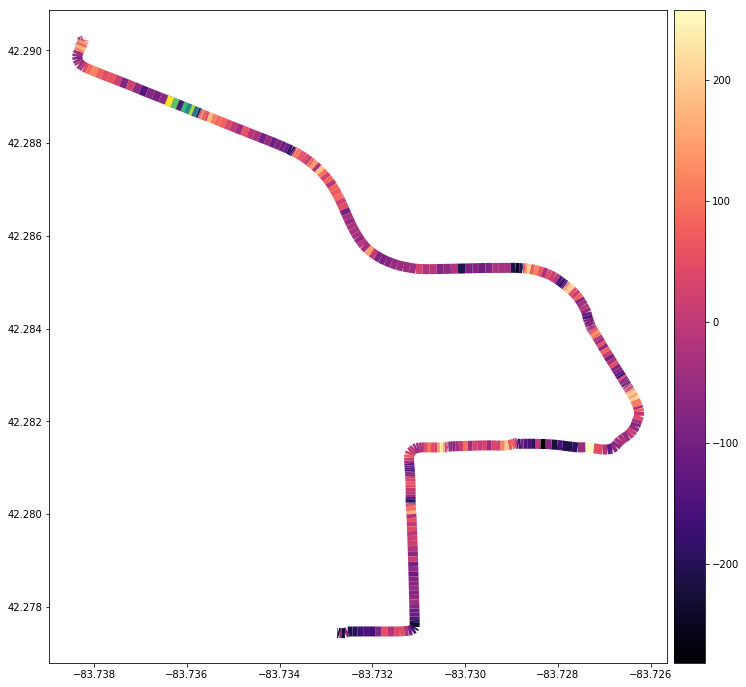

In [321]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig1, ax1 = plt.subplots(1, 1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
Data.plot(column='acc_y',linewidth=10, ax=ax1, legend=True, cmap='magma',vmin=Data['acc_y'].min(),vmax=Data['acc_y'].max(),cax=cax)
Data.iloc[50:60,:].plot(ax=ax1,column='acc_y',linewidth=10)


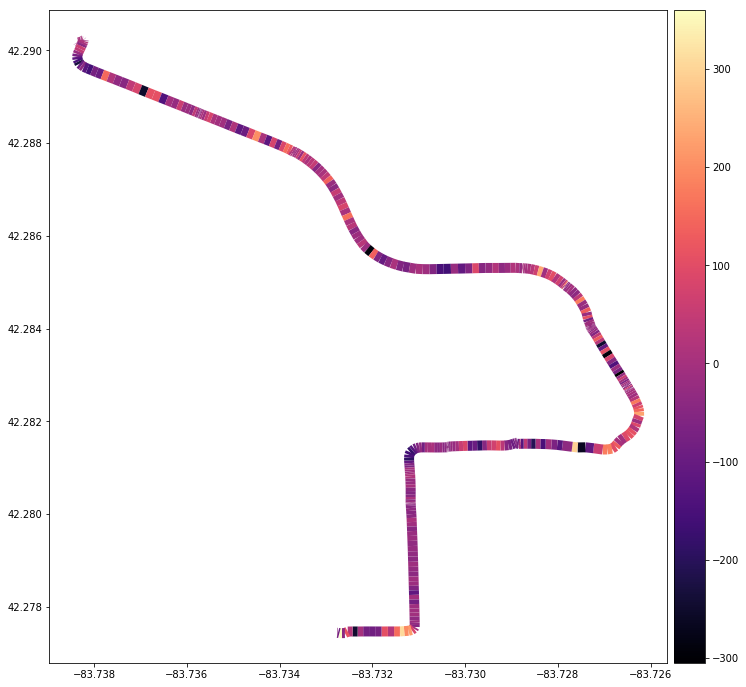

In [251]:
fig1, ax1 = plt.subplots(1, 1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
Data.plot(column='acc_x',linewidth=10, ax=ax1, legend=True, cmap='magma',vmin=Data['acc_x'].min(),vmax=Data['acc_x'].max(),cax=cax)

In [238]:
Data

Longitude   Latitude  Altitude                             Time  \
0   -83.738361  42.290189   203.071 2019-12-09 20:40:53.970000+00:00   
1   -83.738348  42.290183   202.920        2019-12-09 20:40:55+00:00   
2   -83.738345  42.290178   203.092        2019-12-09 20:40:56+00:00   
3   -83.738325  42.290180   204.311        2019-12-09 20:40:57+00:00   
4   -83.738314  42.290180   204.803        2019-12-09 20:40:58+00:00   
5   -83.738304  42.290180   205.392        2019-12-09 20:40:59+00:00   
6   -83.738289  42.290185   205.017        2019-12-09 20:41:00+00:00   
7   -83.738280  42.290190   204.353        2019-12-09 20:41:01+00:00   
8   -83.738275  42.290196   204.983        2019-12-09 20:41:02+00:00   
9   -83.738267  42.290196   205.667        2019-12-09 20:41:03+00:00   
10  -83.738260  42.290200   206.390        2019-12-09 20:41:04+00:00   
11  -83.738256  42.290205   206.993        2019-12-09 20:41:05+00:00   
12  -83.738254  42.290206   207.413        2019-12-09 20:41:06+00:00   
13  -83.738252  42.290205   208.281        2019-12-09 20:41:07+00:00   
14  -83.738255  42.290209   208.941        2019-12-09 20:41:08+00:00   
15  -83.738258  42.290207   209.448        2019-12-09 20:41:09+00:00   
16  -83.738250  42.290210   208.952        2019-12-09 20:41:10+00:00   
17  -83.738243  42.290212   207.963        2019-12-09 20:41:11+00:00   
18  -83.738234  42.290216   206.811        2019-12-09 20:41:12+00:00   
19  -83.738231  42.290217   206.206        2019-12-09 20:41:13+00:00   
20  -83.738227  42.290219   205.503        2019-12-09 20:41:14+00:00   
21  -83.738224  42.290221   205.033        2019-12-09 20:41:15+00:00   
22  -83.738223  42.290223   204.632        2019-12-09 20:41:16+00:00   
23  -83.738224  42.290221   204.556        2019-12-09 20:41:17+00:00   
24  -83.738225  42.290207   204.455        2019-12-09 20:41:18+00:00   
25  -83.738234  42.290181   204.343        2019-12-09 20:41:19+00:00   
26  -83.738251  42.290143   204.094        2019-12-09 20:41:20+00:00   
27  -83.738272  42.290093   203.816        2019-12-09 20:41:21+00:00   
28  -83.738301  42.290034   203.761        2019-12-09 20:41:22+00:00   
29  -83.738330  42.289976   203.594        2019-12-09 20:41:23+00:00   
..         ...        ...       ...                              ...   
623 -83.731103  42.278360   237.382        2019-12-09 20:51:18+00:00   
624 -83.731100  42.278262   237.582        2019-12-09 20:51:19+00:00   
625 -83.731097  42.278161   237.658        2019-12-09 20:51:20+00:00   
626 -83.731095  42.278063   237.642        2019-12-09 20:51:21+00:00   
627 -83.731092  42.277969   237.594        2019-12-09 20:51:22+00:00   
628 -83.731090  42.277879   237.639        2019-12-09 20:51:23+00:00   
629 -83.731088  42.277797   237.526        2019-12-09 20:51:24+00:00   
630 -83.731087  42.277715   237.348        2019-12-09 20:51:25+00:00   
631 -83.731085  42.277659   237.400        2019-12-09 20:51:26+00:00   
632 -83.731086  42.277613   237.440        2019-12-09 20:51:27+00:00   
633 -83.731086  42.277570   237.525        2019-12-09 20:51:28+00:00   
634 -83.731107  42.277536   238.025        2019-12-09 20:51:29+00:00   
635 -83.731152  42.277503   237.855        2019-12-09 20:51:30+00:00   
636 -83.731220  42.277487   237.590        2019-12-09 20:51:31+00:00   
637 -83.731312  42.277480   237.379        2019-12-09 20:51:32+00:00   
638 -83.731404  42.277473   237.449        2019-12-09 20:51:33+00:00   
639 -83.731530  42.277473   236.797        2019-12-09 20:51:34+00:00   
640 -83.731663  42.277473   236.086        2019-12-09 20:51:35+00:00   
641 -83.731800  42.277472   235.590        2019-12-09 20:51:36+00:00   
642 -83.731937  42.277472   235.069        2019-12-09 20:51:37+00:00   
643 -83.732069  42.277473   235.062        2019-12-09 20:51:38+00:00   
644 -83.732196  42.277473   234.824        2019-12-09 20:51:39+00:00   
645 -83.732317  42.277472   234.581        2019-12-09 20:51:40+00:00   
646 -83.732425  42.277472   234.255        20

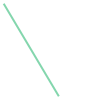

In [227]:
LineString([xyList[1],xyList[2]])

In [204]:
line = LineString([xyList[:-1],xyList[1:]])
line

AssertionError: 